In [1]:
"""
《Students Exam Scores: Extended Dataset可视化与分析预测》
数据集地址：https://www.kaggle.com/datasets/desalegngeb/students-exam-scores
姓名：周企安
学号：0122110870115
班级：软件zy2101
完成日期：2023/5/26
"""
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm.notebook import tqdm

#使用扩展数据集进行分析
df = pd.read_csv(os.path.join('data', 'Expanded_data_with_more_features.csv'))
columns = ['ID', 'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'ParentMaritalStatus', 'PracticeSport',
           'IsFirstChild', 'NrSiblings', 'TransportMeans', 'WklyStudyHours', 'MathScore', 'ReadingScore',
           'WritingScore']
print(f'Data:{df.columns}')

Data:Index(['Unnamed: 0', 'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType',
       'TestPrep', 'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild',
       'NrSiblings', 'TransportMeans', 'WklyStudyHours', 'MathScore',
       'ReadingScore', 'WritingScore'],
      dtype='object')


#### 数据属性与含义
- Unnamed: 0 -> ID
- Gender -> 性别
- EthnicGroup -> 学生所属种族群体
- ParentalEdu -> 父母教育程度
- LunchType -> 午餐类型
- TestPrep -> 考试准备情况
- ParentMaritalStatus -> 父母婚姻状况
- PracticeSport -> 是否参加体育活动
- IsFirstChild -> 是否是家中第一个孩子
- NrSiblings -> 兄弟姐妹数量
- TransportMeans -> 交通方式
- WklyStudyHours -> 每周学习时间
- MathScore -> 数学成绩
- ReadingScore -> 阅读成绩
- WritingScore -> 写作成绩

In [2]:
"""
数据预处理:
    A.重命名列名:Unnamed: 0 -> ID
    B.补全缺失值
    C.修改异常值
"""
print(f'原始缺失值数量：\n{df.isnull().sum()}')
#A.重命名列名
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
#补全缺失值
"""
对比Original_data_with_more_rows.csv（原始数据表）和Expanded_data_with_more_features.csv（扩展数据表）发现：有一些在扩展数据表中的缺失值在原始数据表中是存在的，缺失值的填充方式如下：
1.原始数据表中有的，将其填充到扩充数据表中
2.原始数据表中没有的：
    数值型数据：填充为该类型的平均值（特别的，如果是成绩的数据缺失，则使用他/她自己的平均成绩进行填充）
    类别型数据：填充为该类型的众数所对应的值
"""
#B.1.原始数据表中有的，将其填充到扩充数据表中
df_original = pd.read_csv(os.path.join('data', 'Original_data_with_more_rows.csv'))
for column in columns[1:]:
    #扩充表中有些行是原始表中没有的，所以需要先判断一下是否存在
    if column in df_original.columns:
        df[column].fillna(df_original[column], inplace=True)
#查看是否还有缺失值
print(f'缺失值数量：\n{df.isnull().sum()}')

原始缺失值数量：
Unnamed: 0                0
Gender                    0
EthnicGroup            1840
ParentEduc             1845
LunchType                 0
TestPrep               1830
ParentMaritalStatus    1190
PracticeSport           631
IsFirstChild            904
NrSiblings             1572
TransportMeans         3134
WklyStudyHours          955
MathScore                 0
ReadingScore              0
WritingScore              0
dtype: int64
缺失值数量：
ID                        0
Gender                    0
EthnicGroup               0
ParentEduc                0
LunchType                 0
TestPrep                  0
ParentMaritalStatus    1190
PracticeSport           631
IsFirstChild            904
NrSiblings             1572
TransportMeans         3134
WklyStudyHours          955
MathScore                 0
ReadingScore              0
WritingScore              0
dtype: int64


In [3]:
"""经过上一步发现，缺失值集中在（ParentMaritalStatus, PracticeSport, IsFirstChild, NrSiblings, TransportMeans, WklyStudyHours）这几个属性上，所以我们需要对这几个属性进行处理"""
#B.2.原始数据表中没有的:数值型数据（以上属于数值的只有NrSiblings）
df['NrSiblings'].fillna(int(df['NrSiblings'].mean()), inplace=True)
#B.3.原始数据表中没有的:类别型数据
fillings = ('ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'TransportMeans', 'WklyStudyHours')
for filling in fillings:
    df[filling].fillna(df[filling].mode()[0], inplace=True)
print(f'缺失值数量：\n{df.isnull().sum()}')

缺失值数量：
ID                     0
Gender                 0
EthnicGroup            0
ParentEduc             0
LunchType              0
TestPrep               0
ParentMaritalStatus    0
PracticeSport          0
IsFirstChild           0
NrSiblings             0
TransportMeans         0
WklyStudyHours         0
MathScore              0
ReadingScore           0
WritingScore           0
dtype: int64


D:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


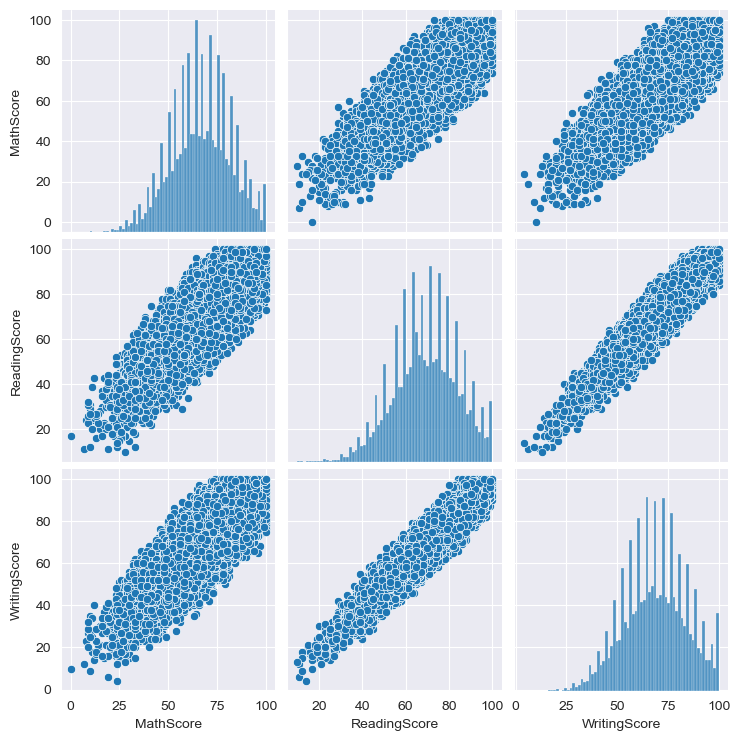

In [4]:
"""
数据分析：成绩关联度可视化
尽管直觉上，我们可以认为数学成绩、阅读成绩和写作成绩之间存在某种关系，但是我们需要通过可视化来证明这一点。
"""
#用seaborn绘制数学成绩、阅读成绩和写作成绩两两之间的关系
sns.pairplot(df, x_vars=['MathScore', 'ReadingScore', 'WritingScore'],
             y_vars=['MathScore', 'ReadingScore', 'WritingScore'], kind='scatter')

从以上的可视化结果可以看出，数学成绩、阅读成绩和写作成绩之间存在着一定的关系，并且这种关系是近乎线性的，所以我们可以使用线性回归模型来预测学生的成绩。

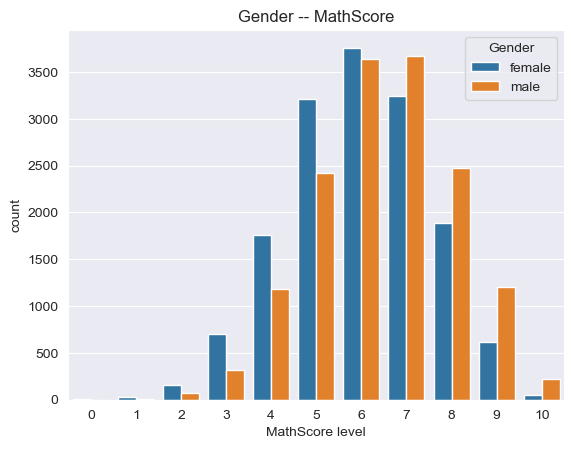

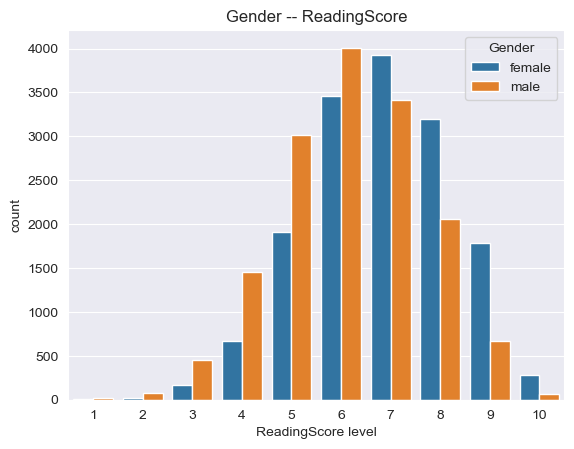

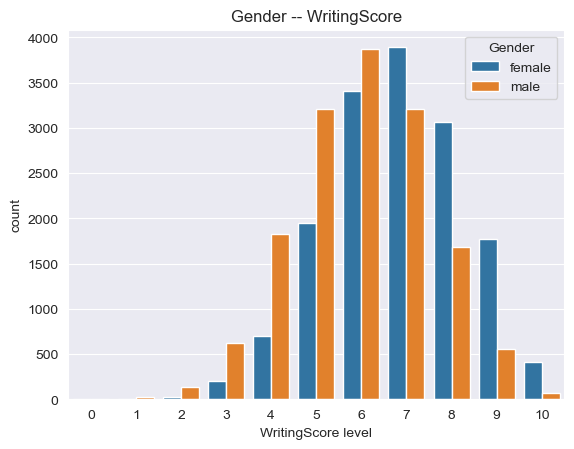

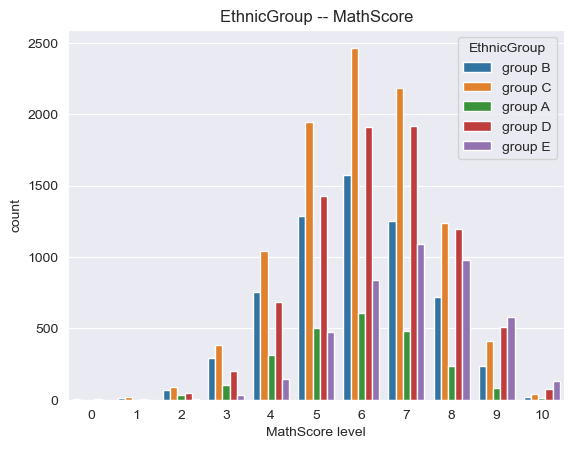

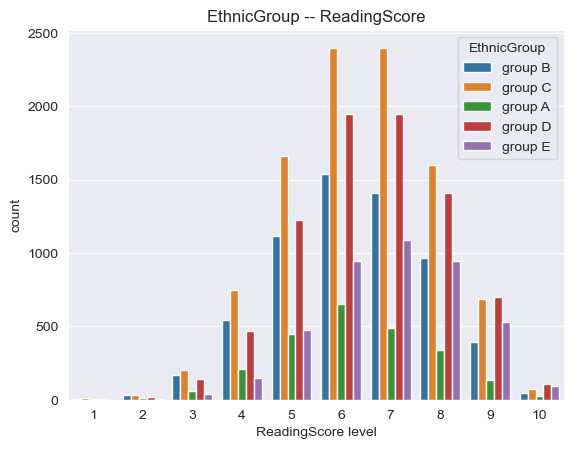

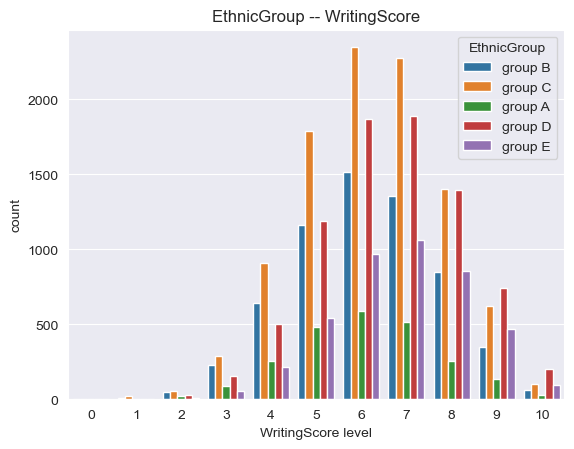

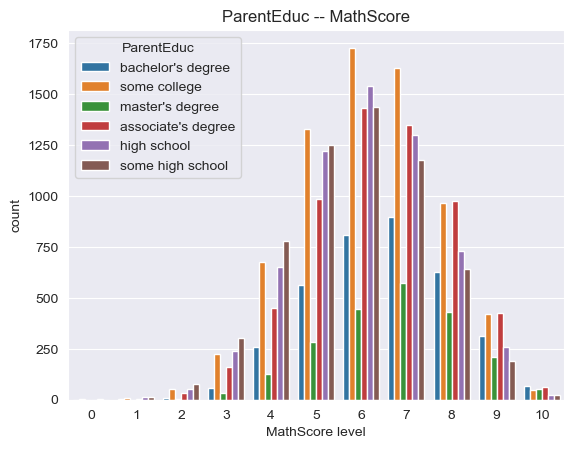

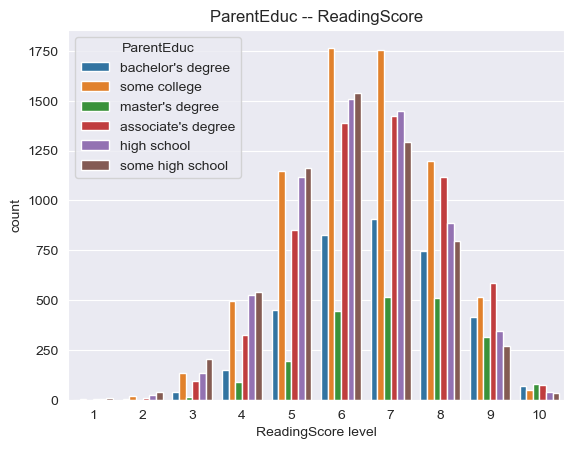

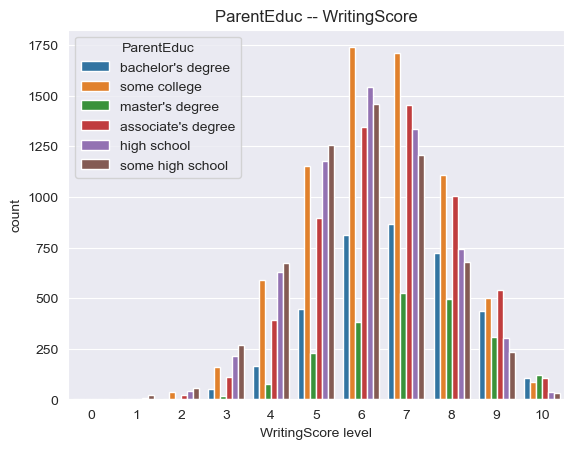

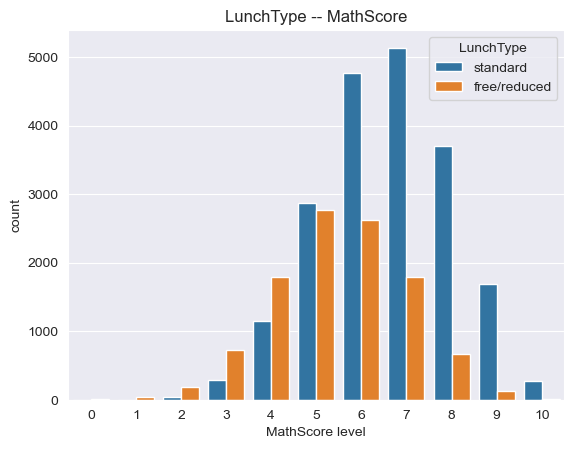

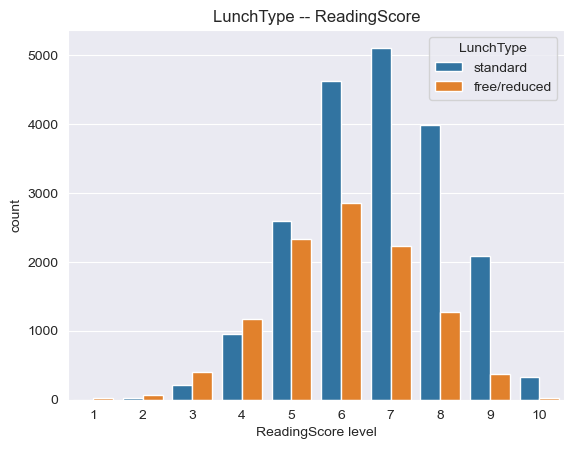

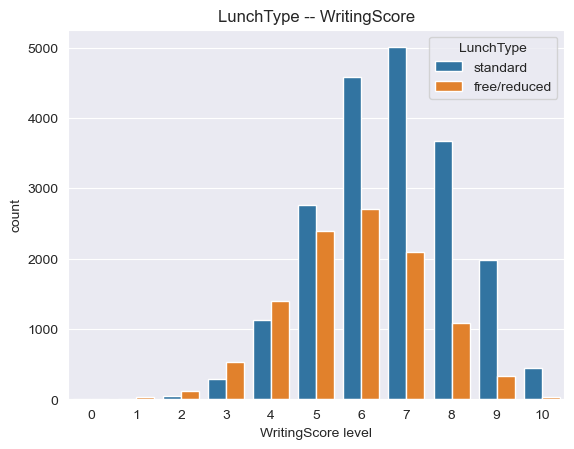

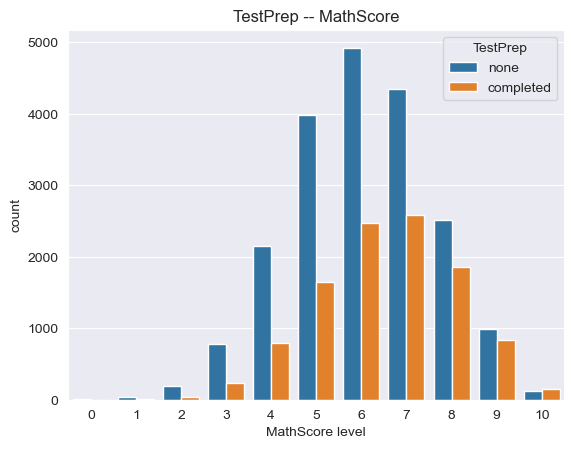

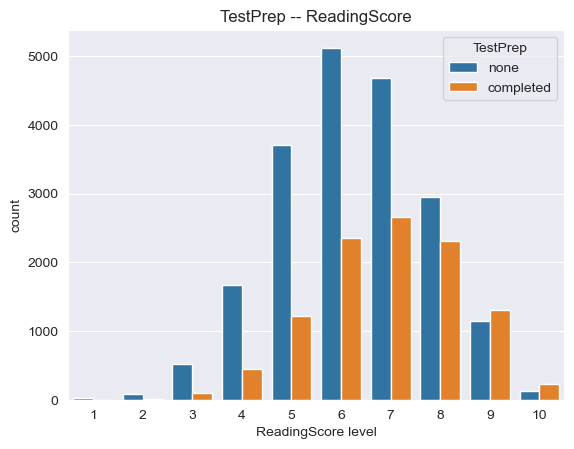

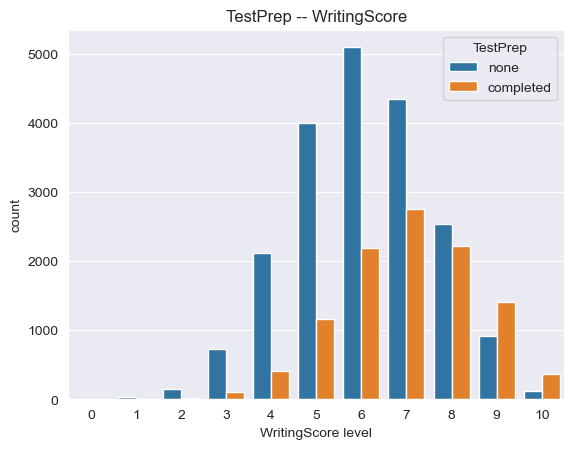

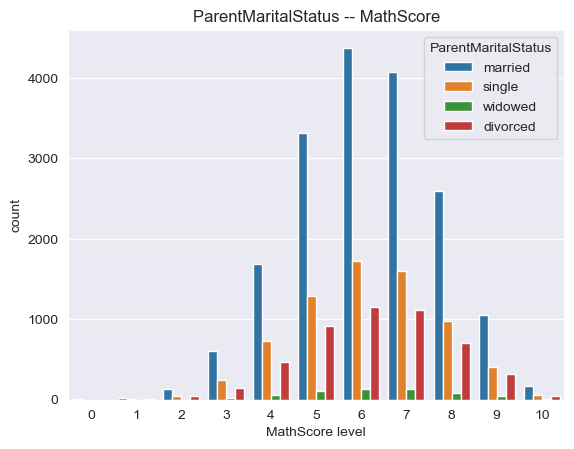

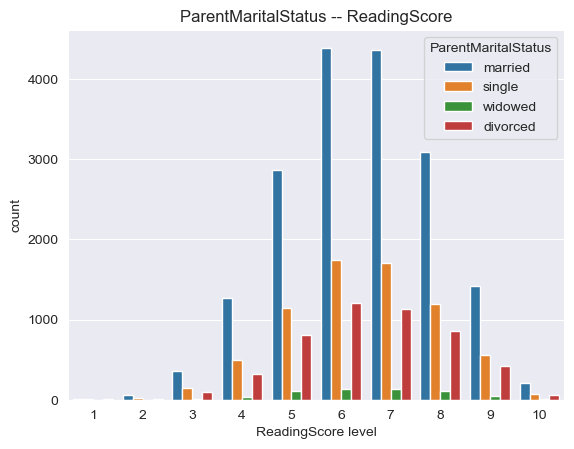

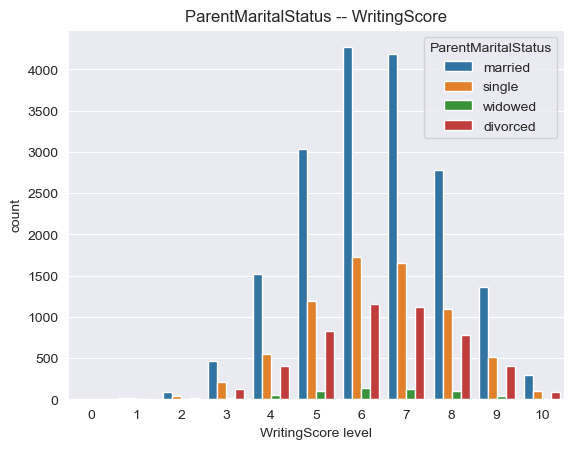

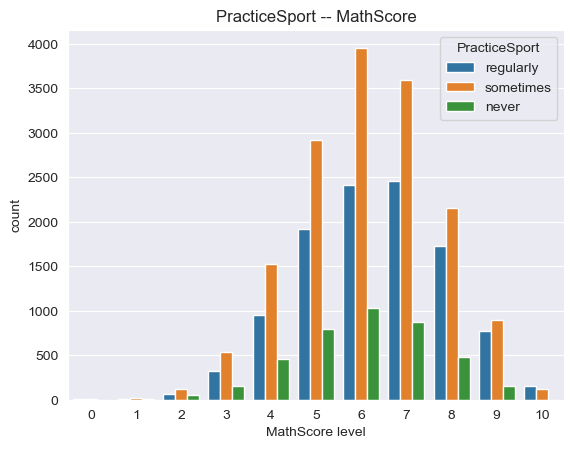

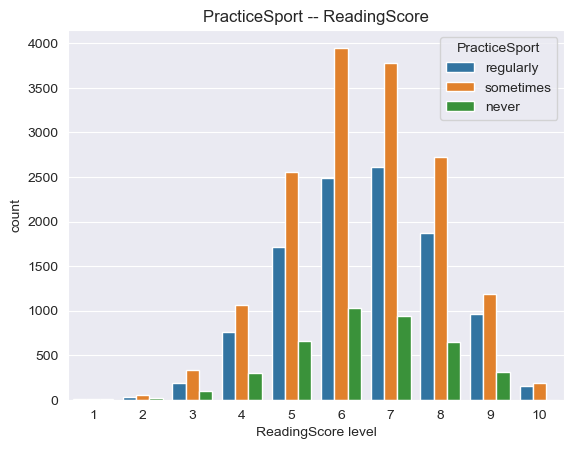

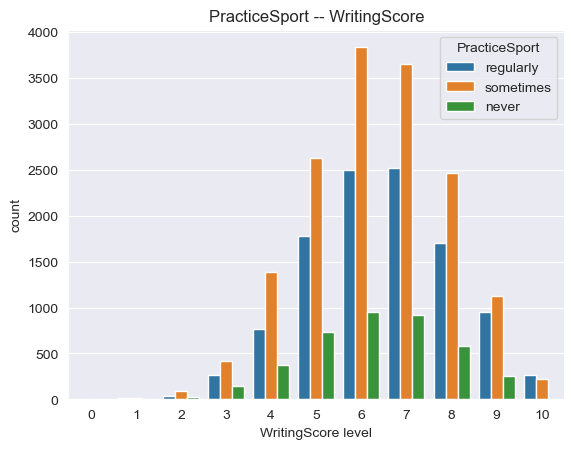

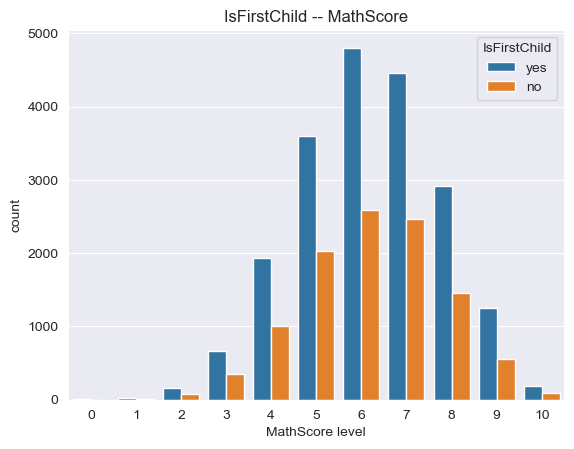

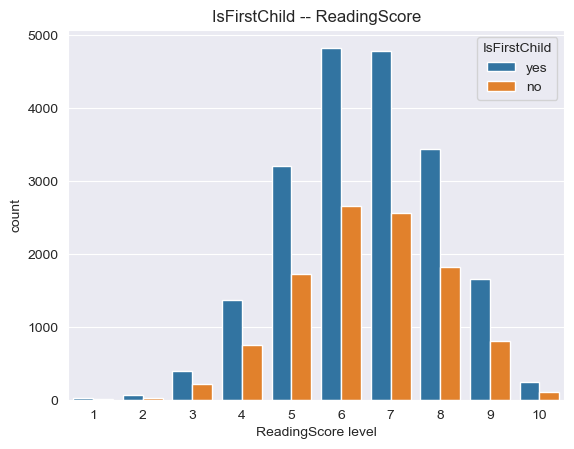

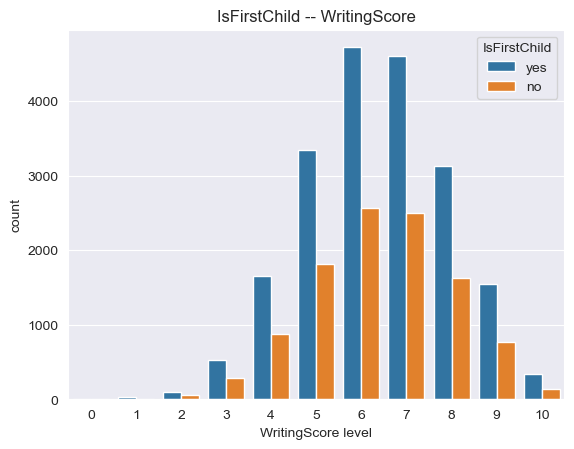

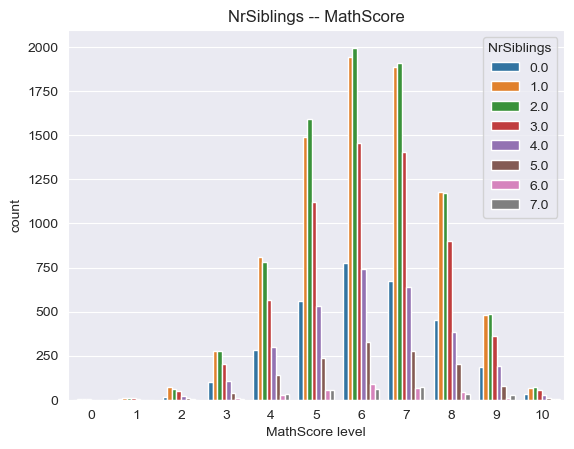

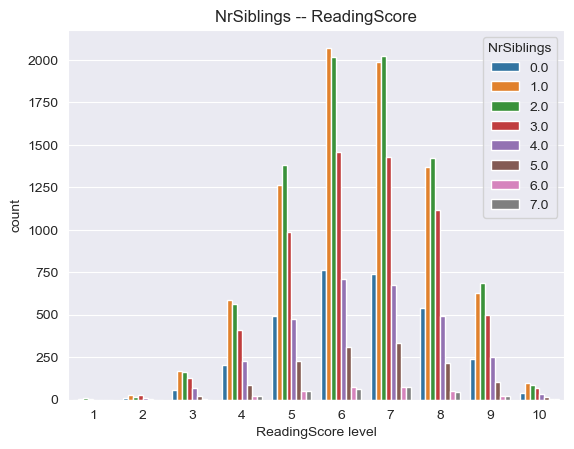

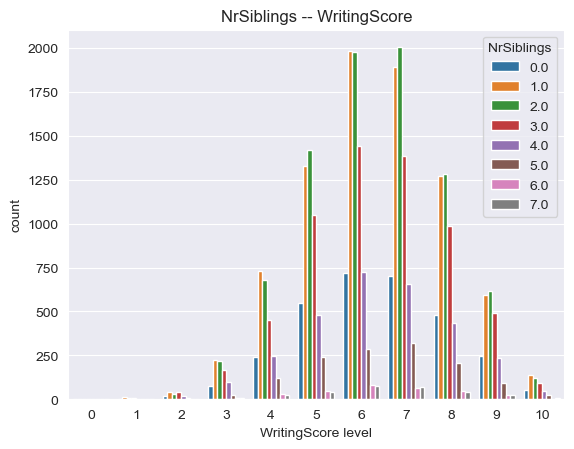

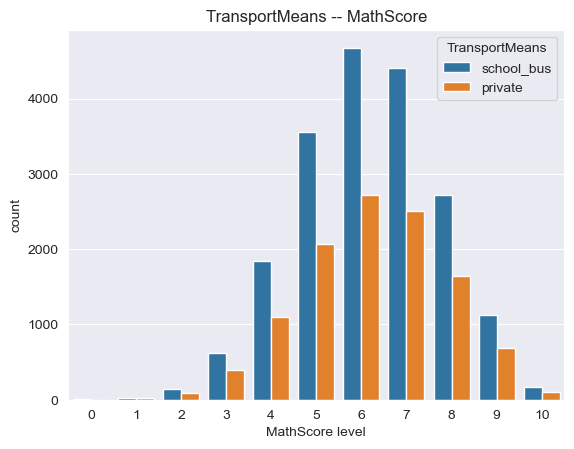

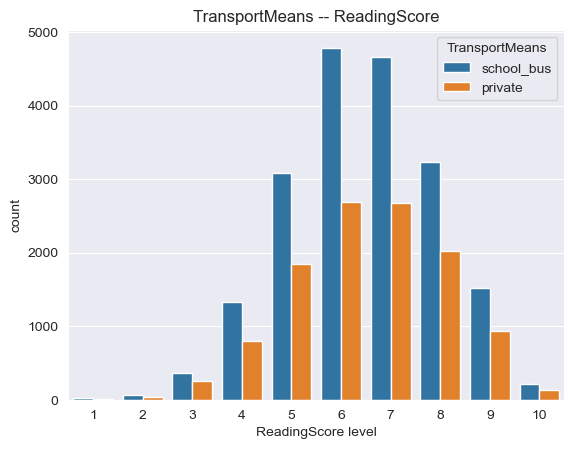

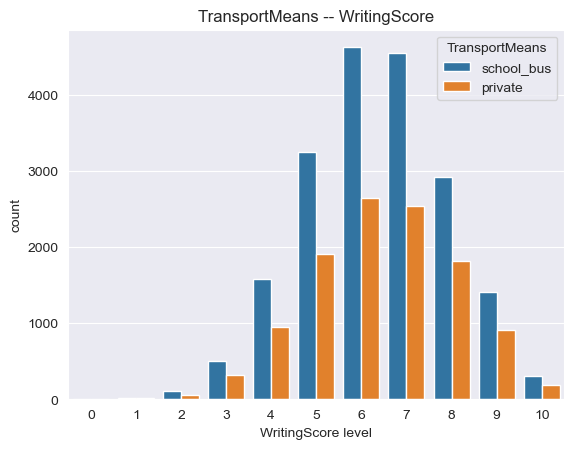

In [5]:
"""
数据分析：影响因素关联度可视化
对于Gender、EthnicGroup、ParentalEdu、LunchType、TestPrep、ParentMaritalStatus、PracticeSport、IsFirstChild、NrSiblings、TransportMeans、WklyStudyHours这些因素与成绩之间的关系进行可视化分析。
"""

score = columns[12:]
factors = columns[1:11]
#将成绩按照每10分一个区间，用0代表0-10分，1代表11-20分，以此类推
for s in score:
    df[s + ' level'] = df[s].astype(int)
    df[s + ' level'] = df[s + ' level'] // 10
for factor in factors:
    #使用seaborn绘制因素与成绩之间的关系，绘制柱状图：每张图x为成绩的区间（分开成三个成绩），y为因素的人数
    for s in score:
        sns.countplot(x=s + ' level', hue=factor, data=df)
        plt.title(f'{factor} -- {s}')
        plt.show()

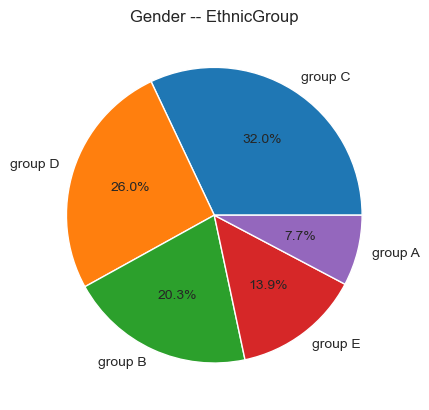

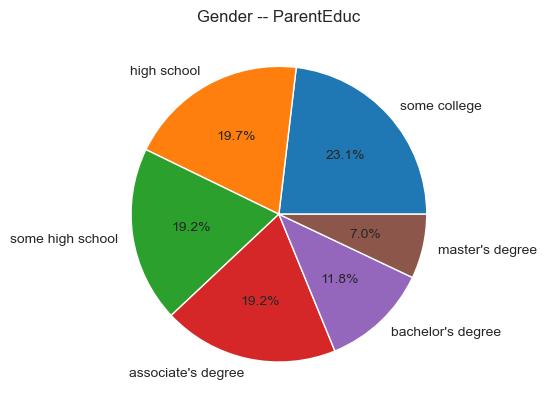

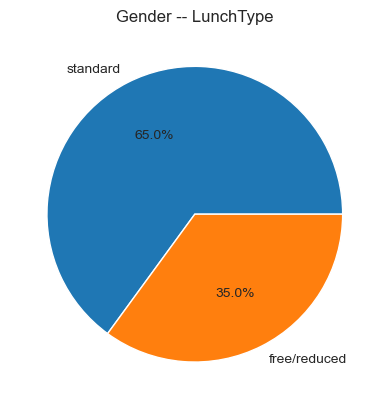

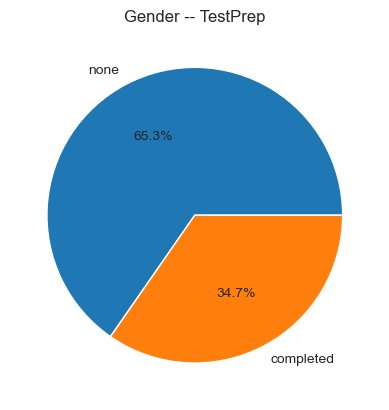

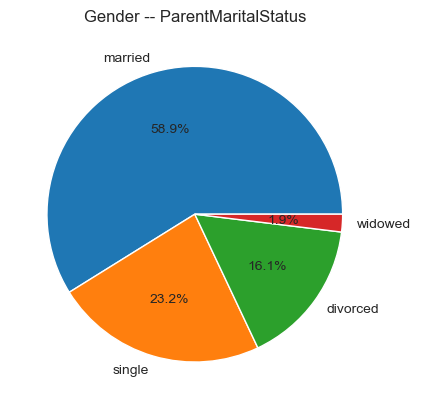

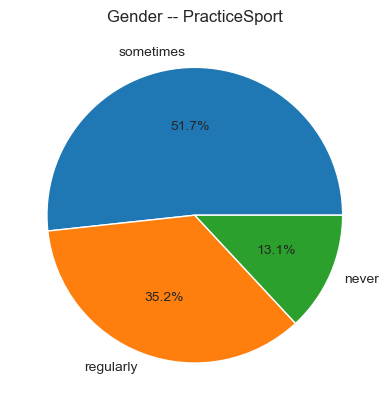

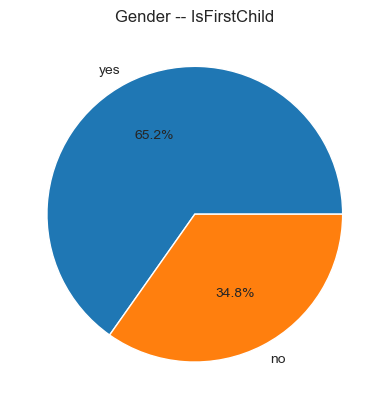

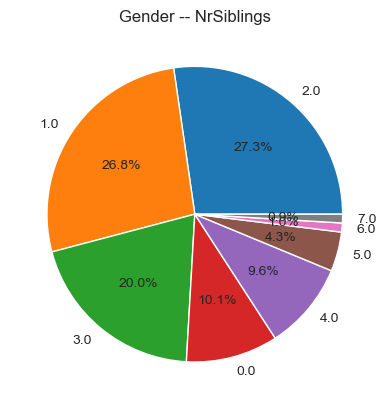

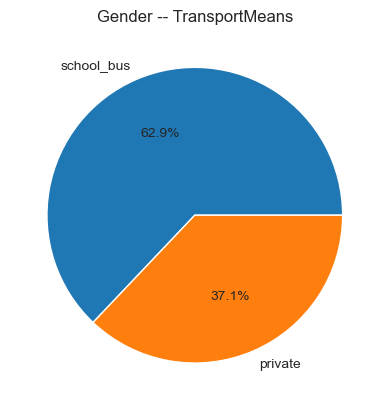

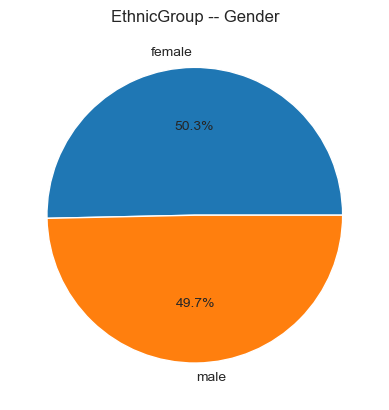

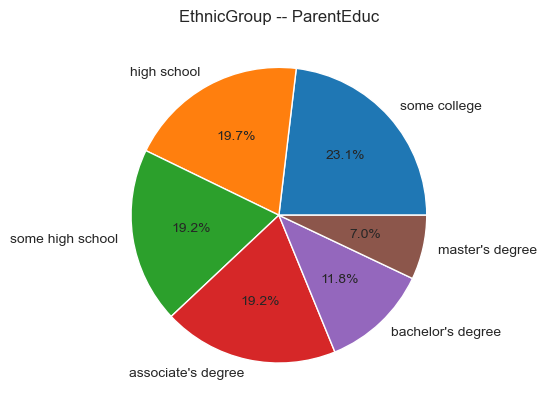

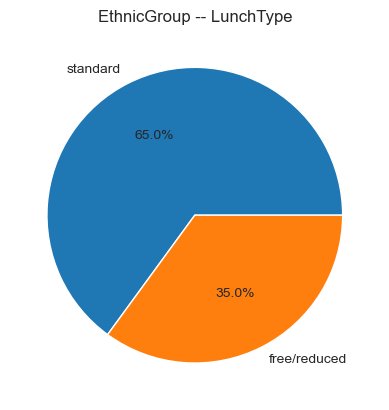

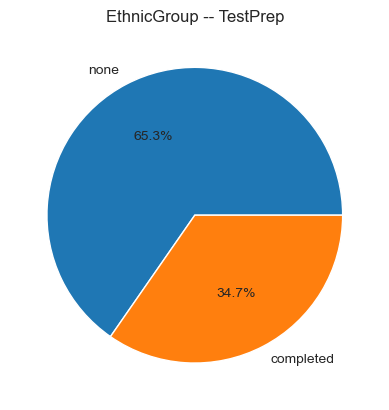

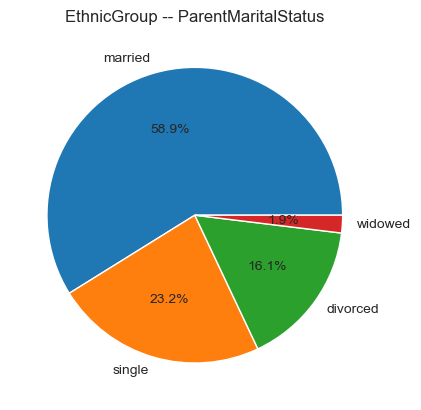

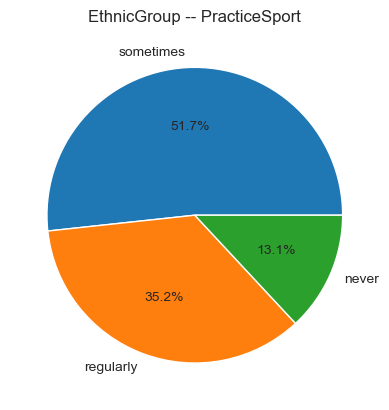

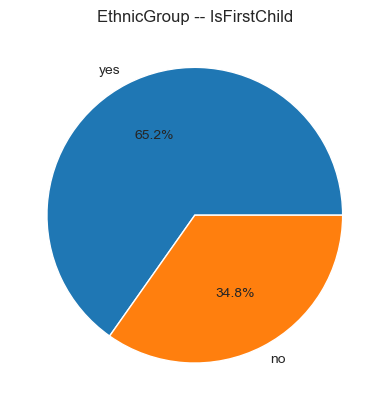

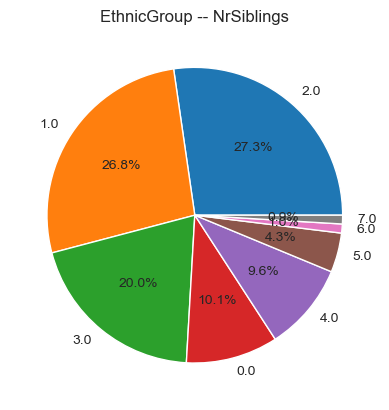

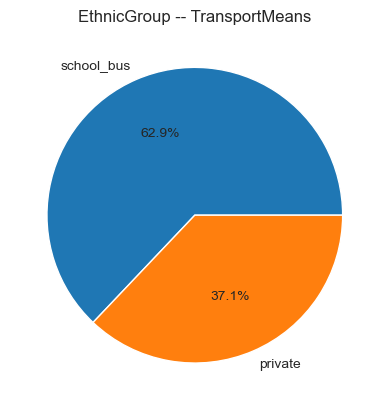

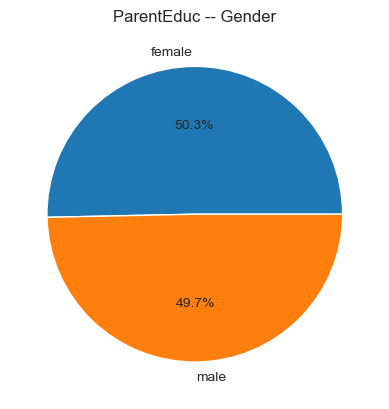

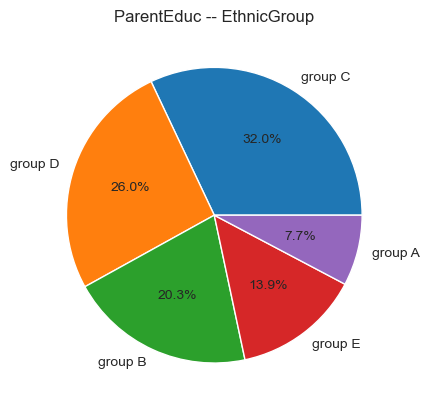

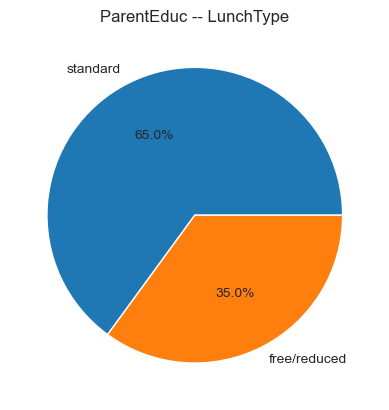

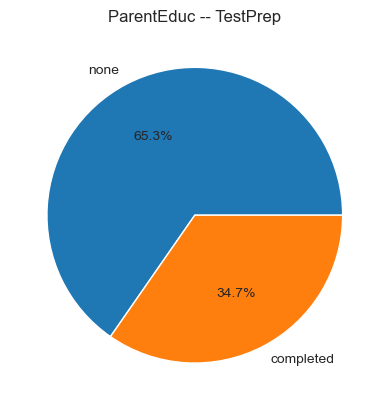

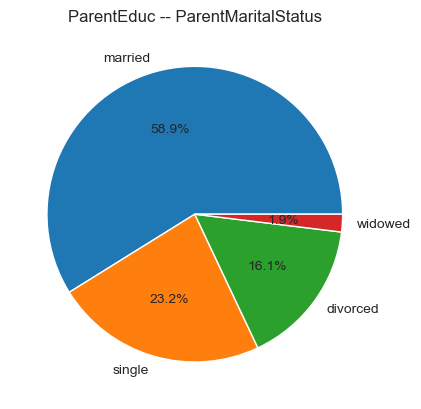

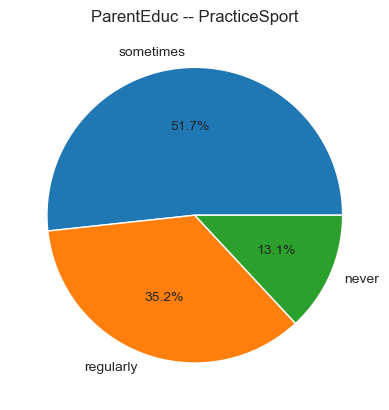

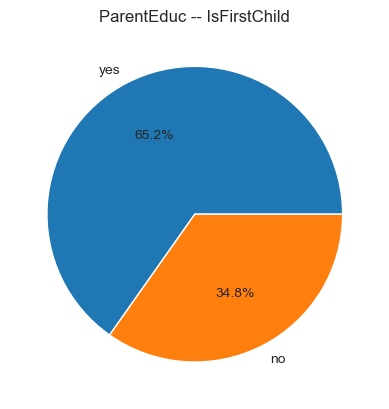

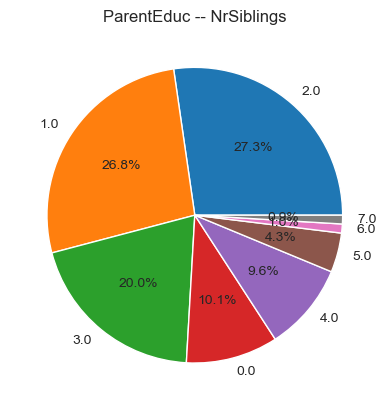

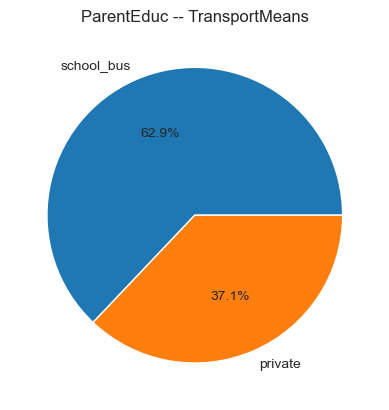

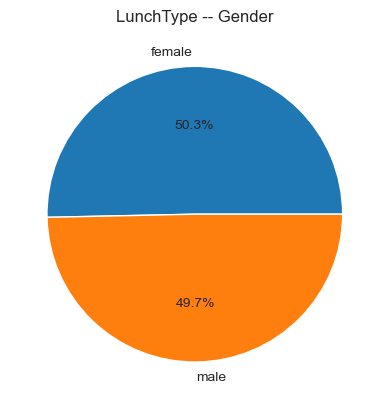

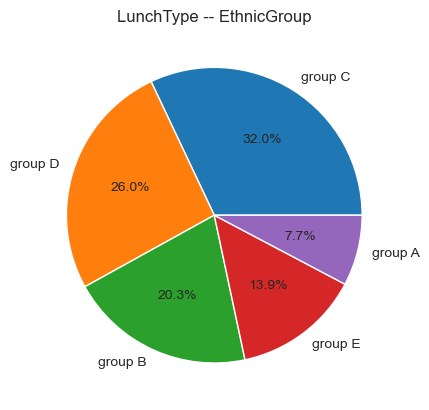

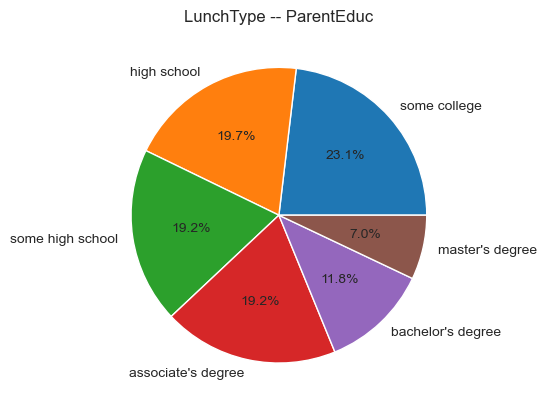

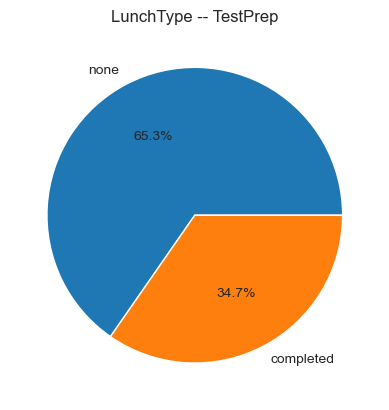

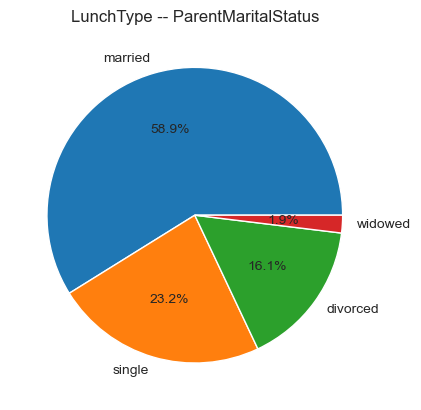

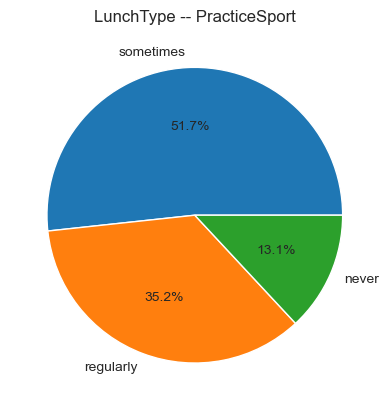

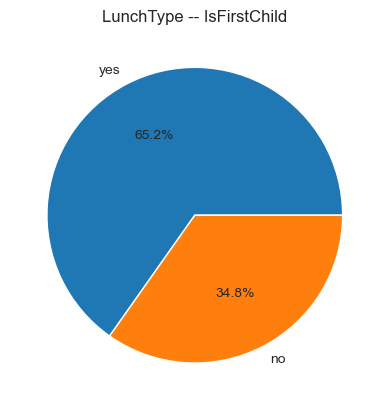

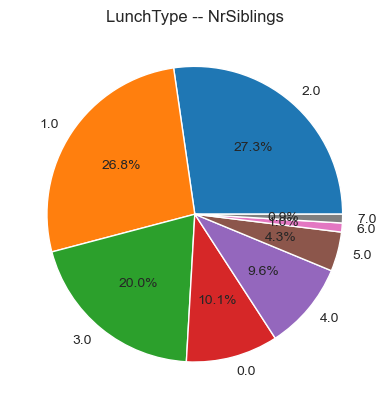

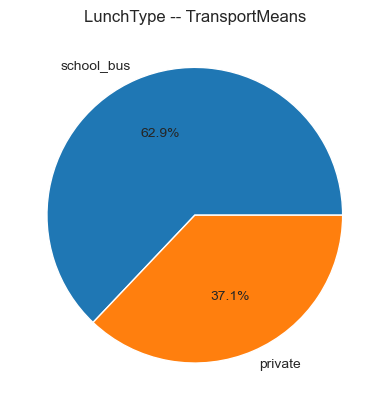

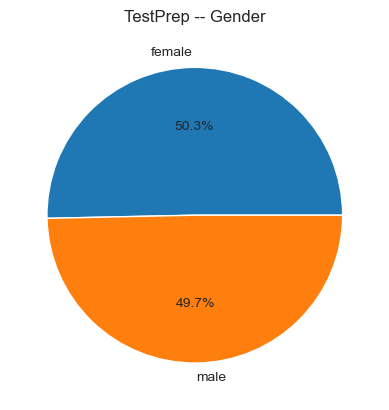

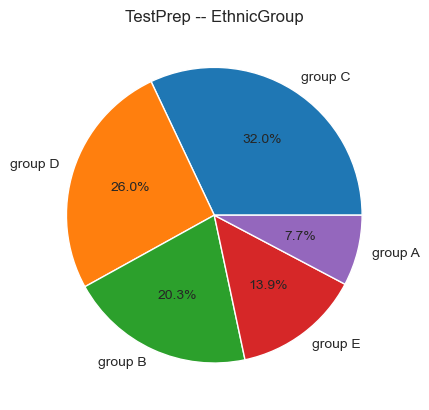

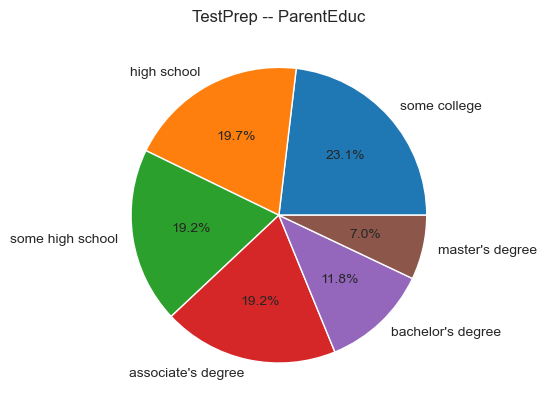

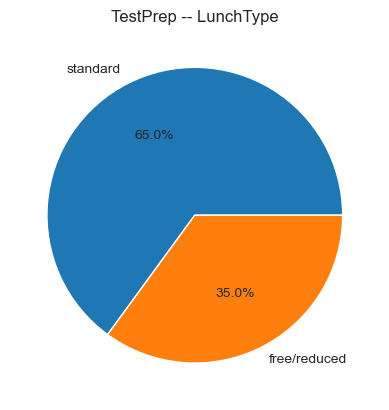

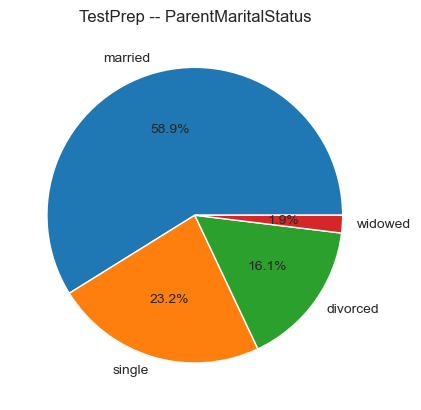

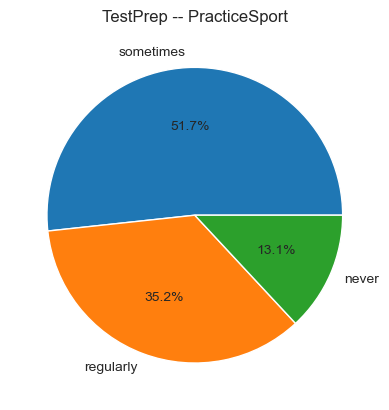

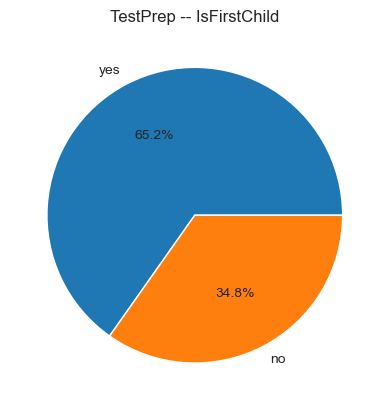

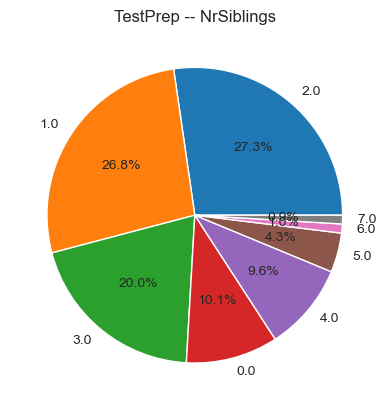

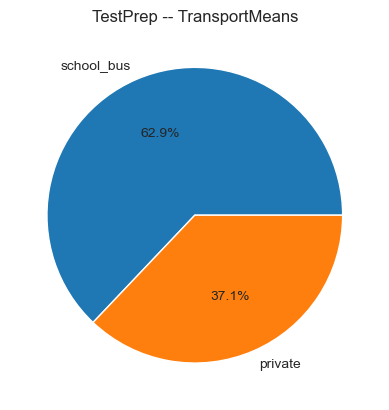

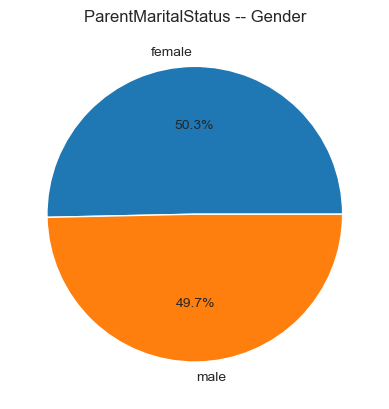

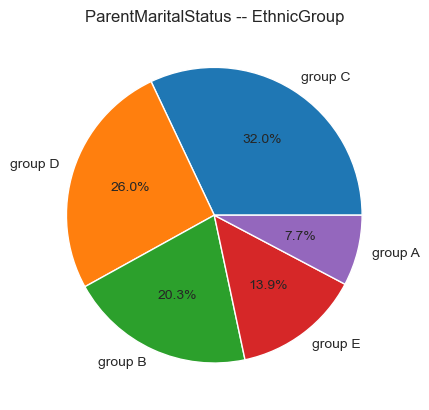

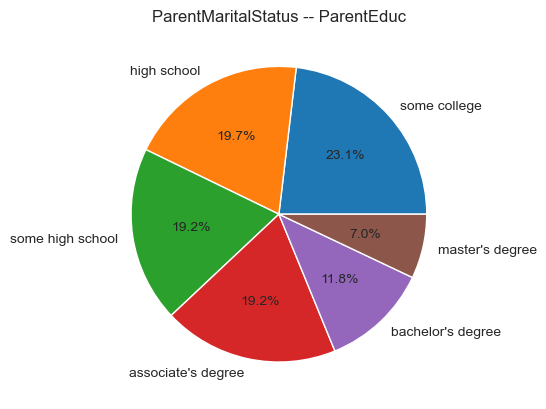

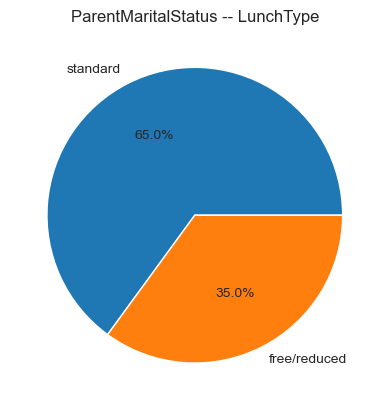

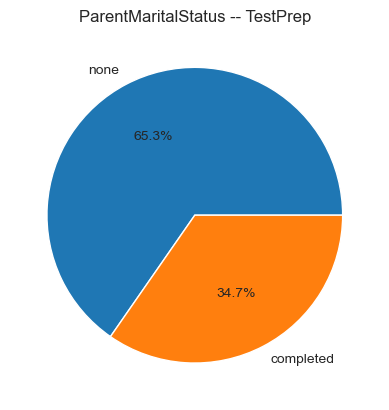

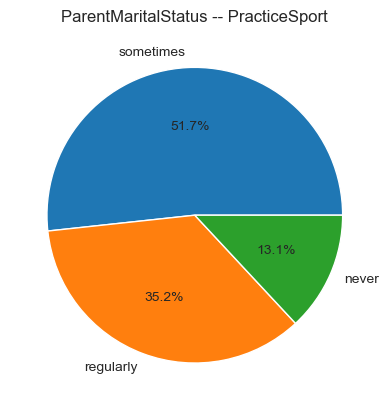

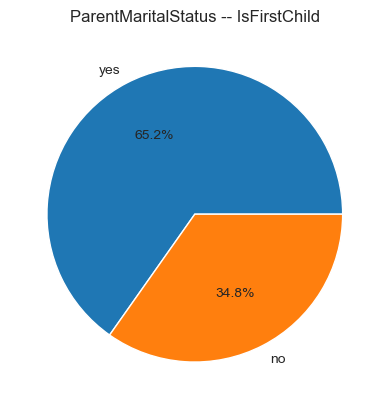

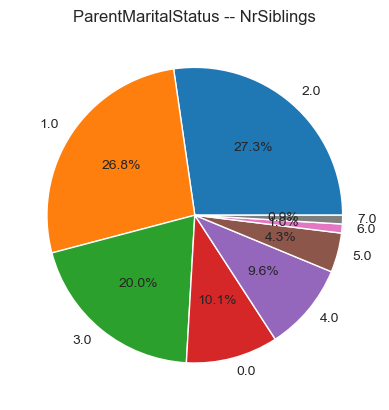

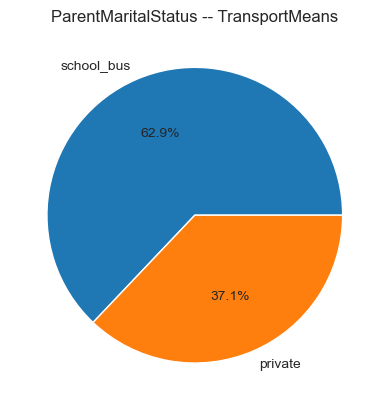

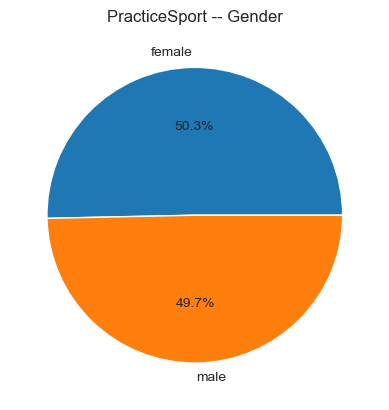

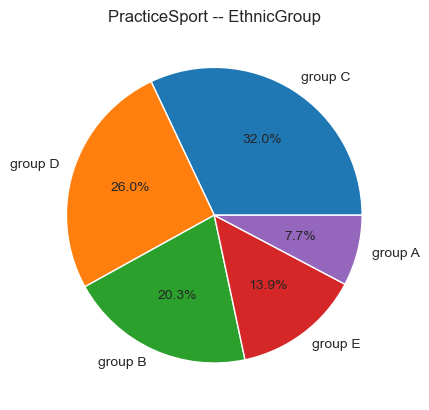

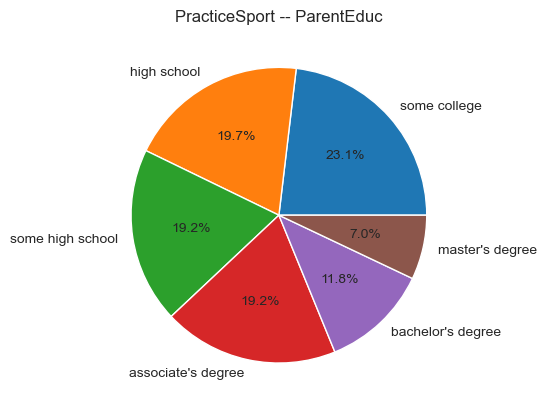

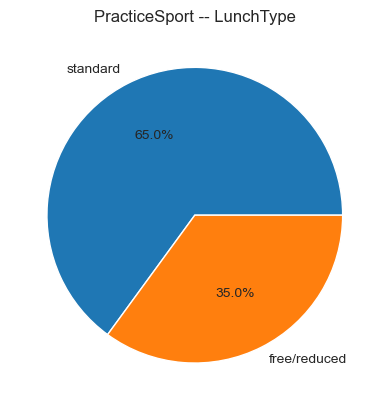

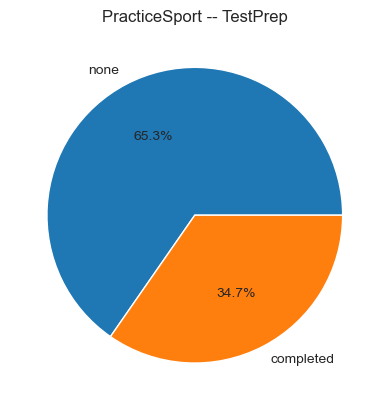

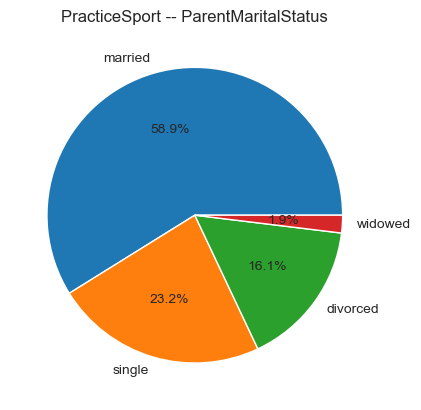

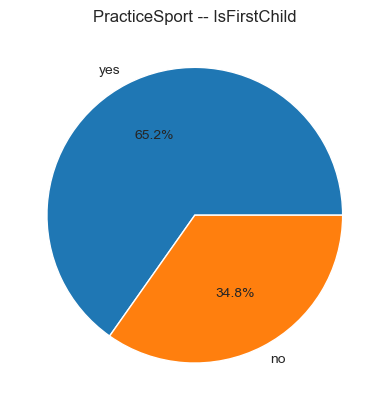

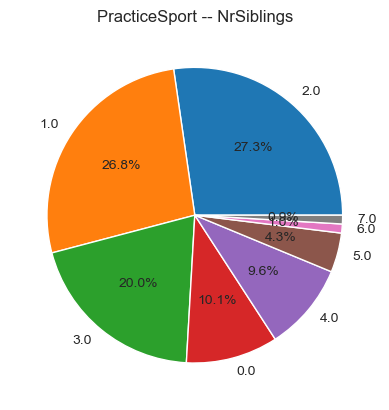

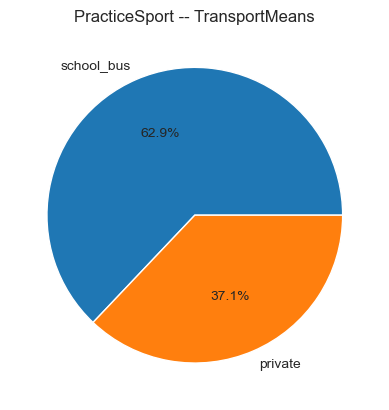

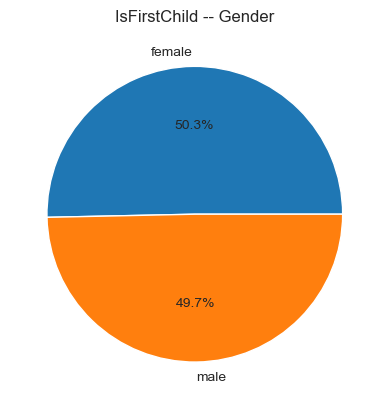

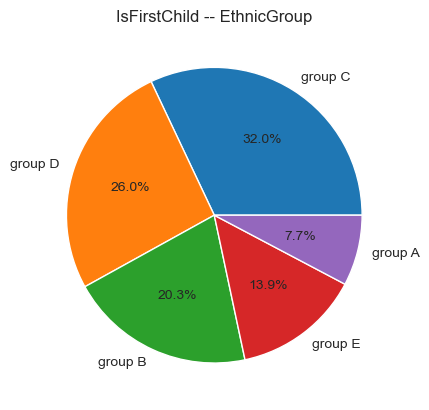

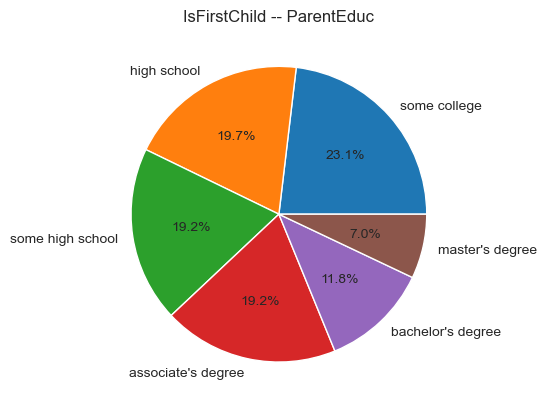

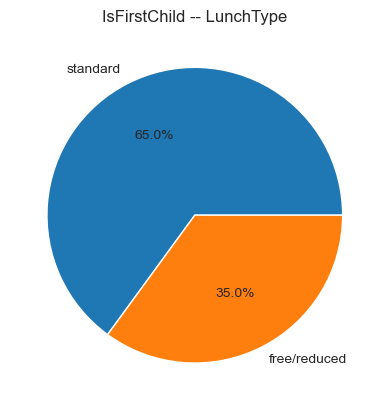

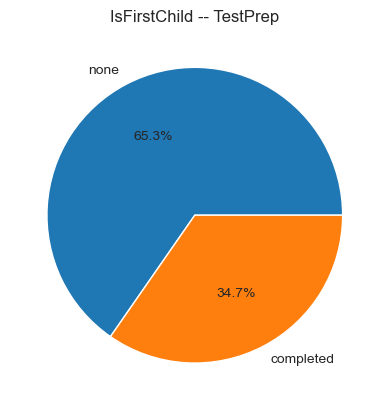

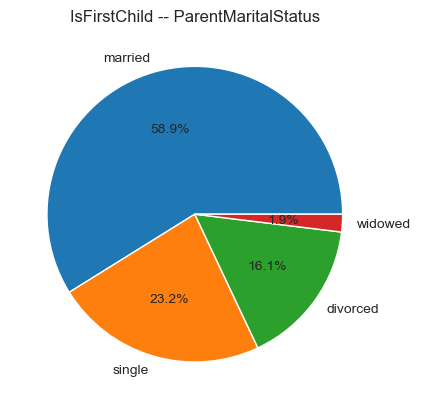

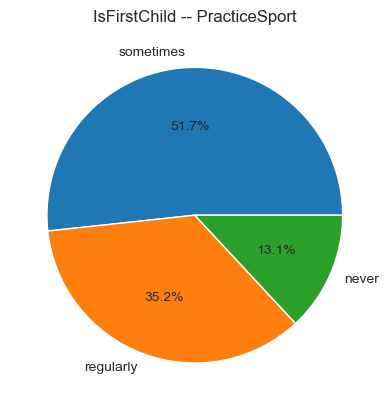

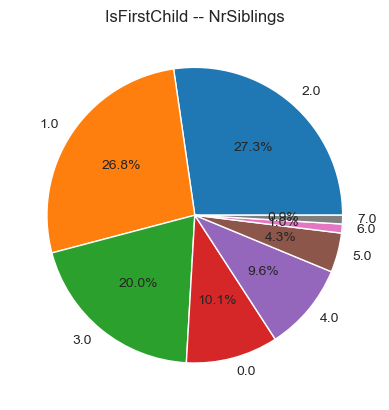

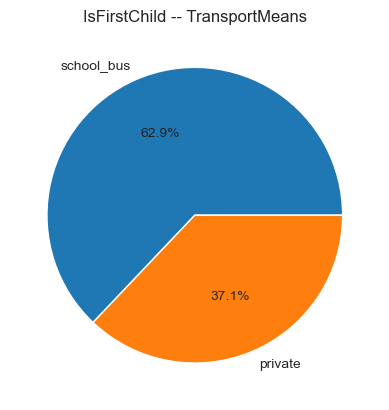

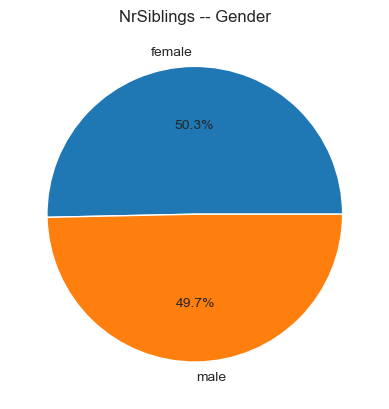

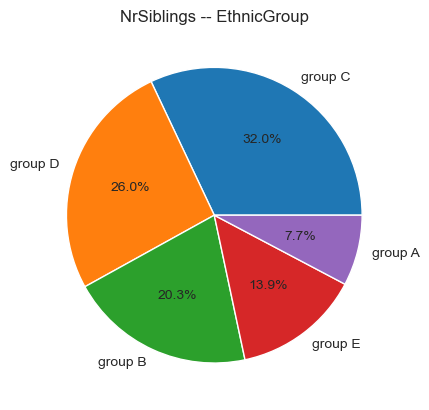

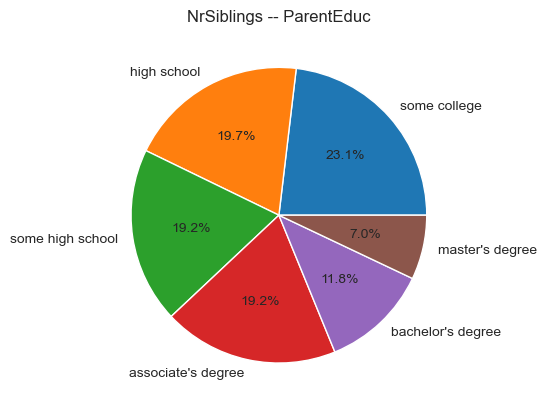

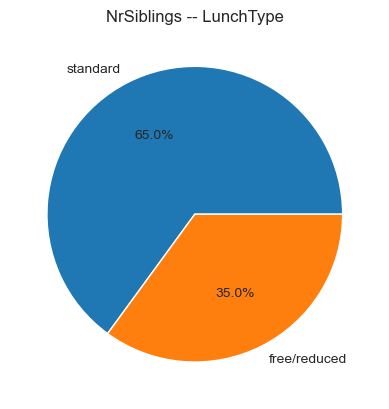

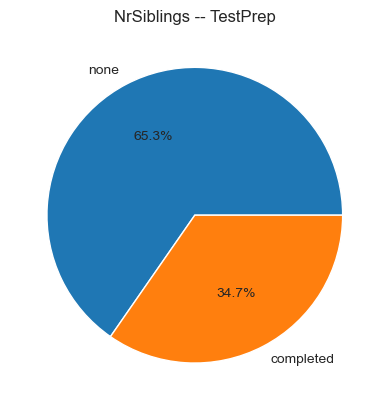

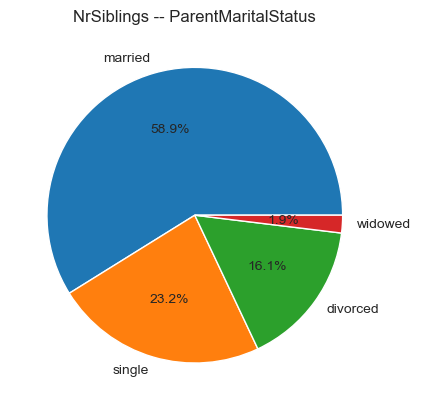

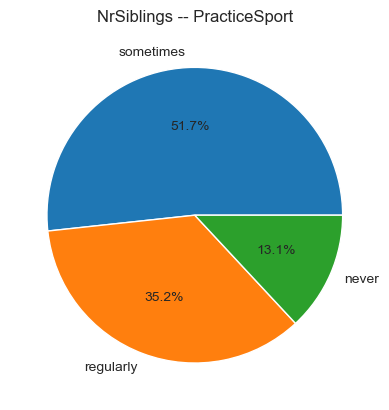

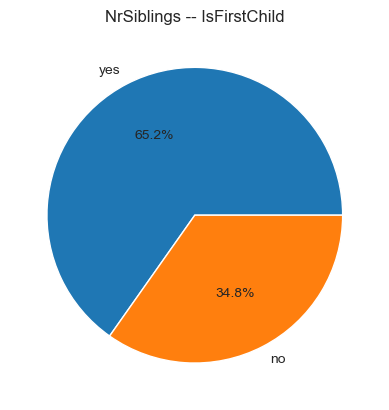

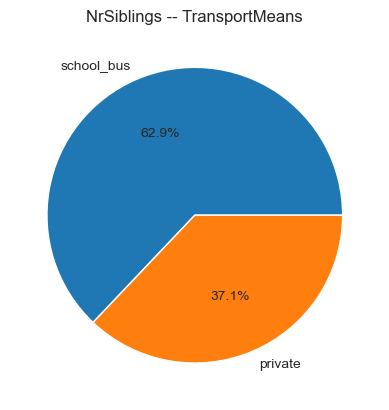

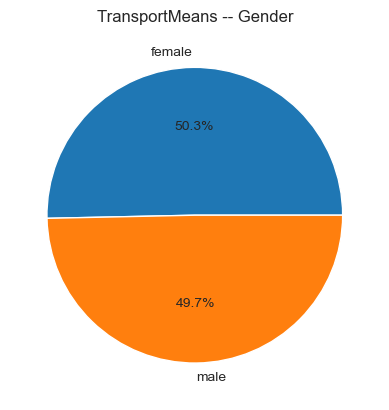

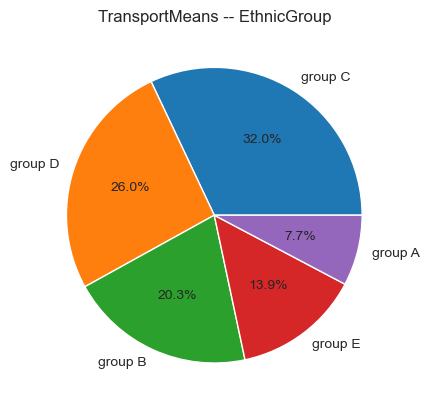

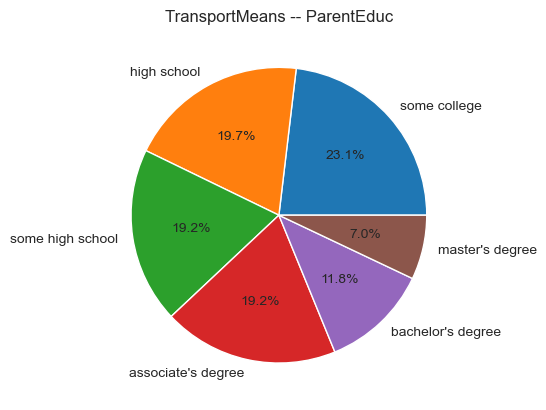

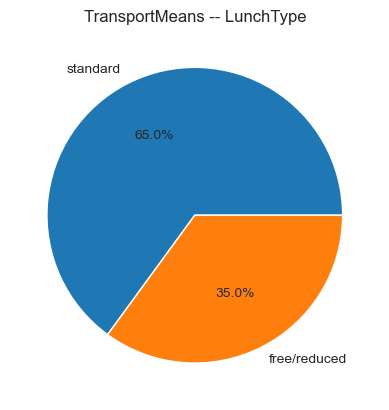

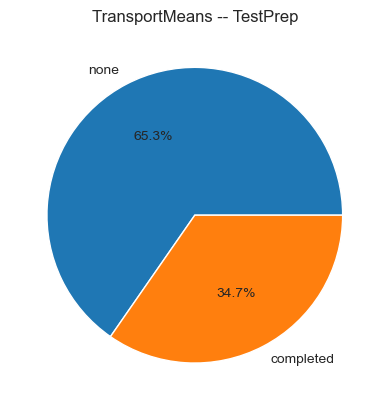

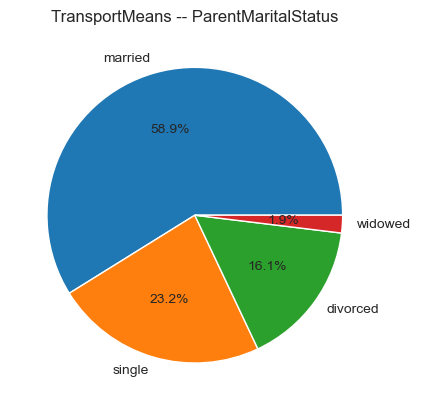

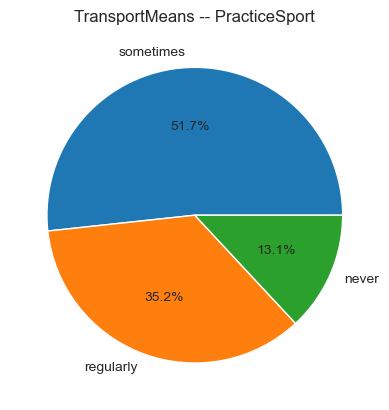

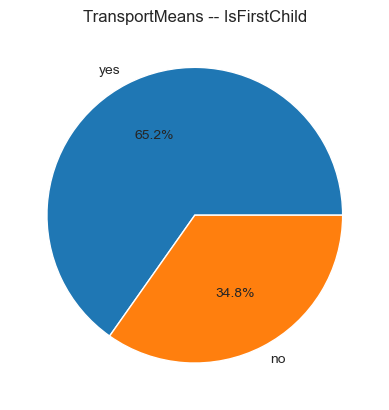

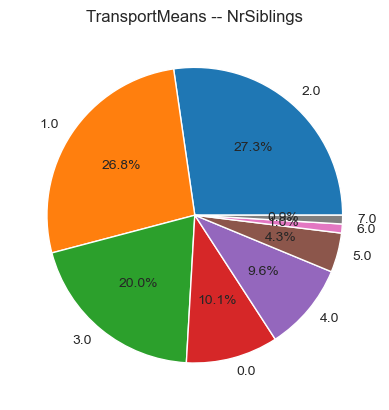

In [6]:
"""
数据分析：影响因素关联度可视化
对于Gender、EthnicGroup、ParentalEdu、LunchType、TestPrep、ParentMaritalStatus、PracticeSport、IsFirstChild、NrSiblings、TransportMeans、WklyStudyHours这些因素它们之间的关系进行可视化分析。
"""
#这次采取饼状图的方式进行可视化，观察一个因素的情况下，成绩的分布情况
#的关系，绘制饼状图：每张图x其中一个因素，y为另一个因素
for factor in factors:
    for s in factors:
        if factor == s:
            continue
        #计算每个因素的人数
        factor_count = df[factor].value_counts()
        #计算每个因素的人数所占比例
        factor_percent = factor_count / factor_count.sum()
        #计算每个因素的人数所占比例
        score_count = df[s].value_counts()
        #计算每个因素的人数所占比例
        score_percent = score_count / score_count.sum()
        #绘制饼状图
        plt.pie(score_percent, labels=score_count.index, autopct='%1.1f%%')
        plt.title(f'{factor} -- {s}')
        plt.show()

In [7]:
"""成绩预测：使用pytorch神经网络对学生的成绩进行预测"""
#给类别型数据转化成数字，并将数字与对应的类别存储在字典中。例：对于IsFirstChild属性，将no编码为0，yes编码为1，之后创建字典{0:'no', 1:'yes'}
dict_list = list()
for column in columns[1:12]:
    diction = dict()
    for i, value in enumerate(df[column].unique()):
        diction[value] = i
    dict_list.append(diction)
#将类别型数据转化成数字
for i, column in enumerate(columns[1:12]):
    df[column] = df[column].map(dict_list[i])
#将数据集分为训练集和测试集
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
#将训练集和测试集中的数据分为输入和输出，并转换成numpy数组
train_x = train_df[columns[1:12]].values
train_y = train_df[columns[12:]].values
test_x = test_df[columns[1:12]].values
test_y = test_df[columns[12:]].values
#将numpy数组转换成tensor，不一步到位是因为一步到位有点问题
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()

In [8]:
"""构建神经网络"""


class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


loss_f = nn.MSELoss()
net = MyNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
"""训练神经网络"""
#设置训练次数
epochs = 1000
#设置训练集和测试集的损失值
train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):
    #将梯度初始化为0
    optimizer.zero_grad()
    #将训练集输入神经网络，得到预测值
    train_output = net(train_x)
    #计算训练集的损失值
    train_loss = loss_f(train_output, train_y)
    #将训练集的损失值加入到train_losses中
    train_losses.append(train_loss)
    #将测试集输入神经网络，得到预测值
    test_output = net(test_x)
    #计算测试集的损失值
    test_loss = loss_f(test_output, test_y)
    #将测试集的损失值加入到test_losses中
    test_losses.append(test_loss)
    #反向传播
    train_loss.backward()
    #更新参数
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

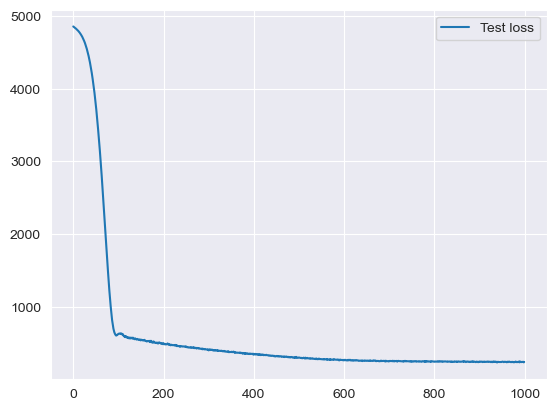

In [10]:
#test_losses中存储的是tensor，需要将其转换成numpy数组
test_losses = [i.detach().numpy() for i in test_losses]
#损失可视化
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

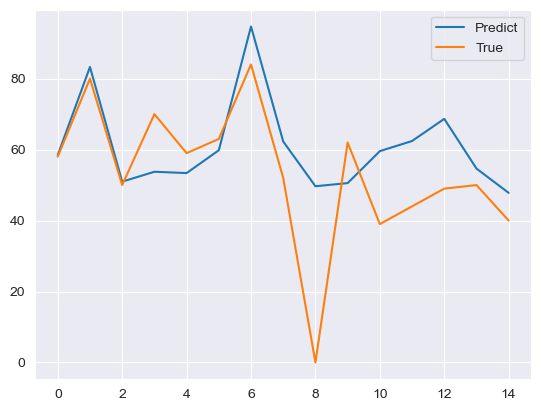

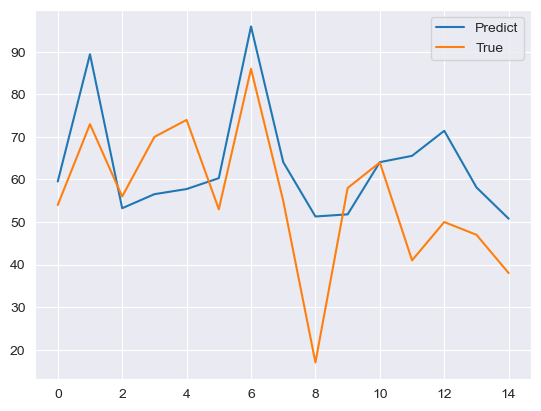

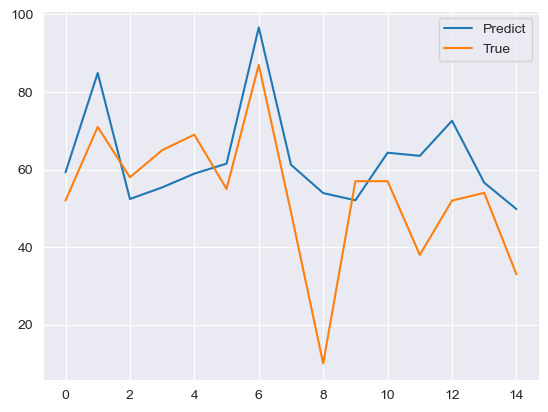

In [11]:
#预测，展示预测值与真实值的对比
test_output = net(test_x)
test_output = test_output.detach().numpy()
test_y = test_y.detach().numpy()
for i in range(3):
    plt.plot(test_output[:15, i], label='Predict')
    plt.plot(test_y[:15, i], label='True')
    plt.legend()
    plt.show()

In [12]:
torch.save(net.state_dict(), 'net_params.pkl')